In [12]:
#사용할 수 있는 장치를 알려주는 코드
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11896794298049377862,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1218258424309019341
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5615647587167693483
 physical_device_desc: "device: XLA_GPU device"]

In [13]:
gpus = tf.config.experimental.list_physical_devices('XLA_GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


## Error

model을 설계할 때 tuple has not attribute 'layer'라는 에러 발생

-> keras의 버전 문제

아래 library import에서 from keras -> from tensorflow.keras로 고쳐서 해결

tensorflow.keras를 사용하면 tensorflow에 번들로 딸려오는 keras를 사용하는것


tensorflow 2버전에서 GPU를 사용하지 않는 문제

 - cuda 재설치 (10.1버전) 그에맞는 cudnn 안의 폴더에 매칭하는 cuda폴더로 파일 넣기 (덮어쓰기 xxxx) 
 
 - 환경변수 설정
 
 - jupyter로그에서 GPU library를 불러오지 못한다고 함 (cudnn64_7.dll) 그래서 cudnn 7버전으로 다시 깔았더니 됨

## Python import

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import cv2
# from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input.

# from tensorflow.keras.layers import Embedding
# from keras import models
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers # L2규제

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

#from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

## Load Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

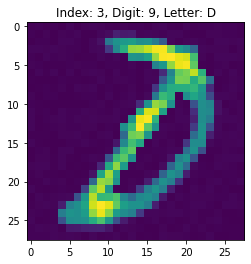

In [36]:
idx = 3
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

## preprocessing (equalization,stretching)

이미지 크기를 3배로 확대 (28x28 -> 84x84) 후 원본, 평활화, 스트레칭

안해본 것 : 이진화, 모폴로지연산(열림, 닫힘) 
 
 - 모폴로지는 크게 효과x, 이진화는 효과가 좋을거라 예상

In [3]:
#이미지 크기 확대
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') #resize에러 float32로 바꿔 해결함
x_train = [cv2.resize(im,dsize=(84,84),interpolation=cv2.INTER_LINEAR) for im in x_train]
#x_train = x_train/255 # data 정규화
#img=x_train[0].reshape(28,28).astype(int)

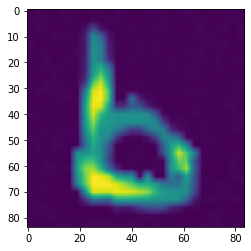

In [63]:
plt.imshow(x_train[1]) #3배로 확대만 한 원본

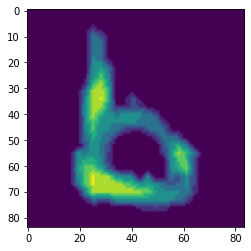

In [64]:
a=stretch_img(x_train[1]) #스트레칭
plt.imshow(a)

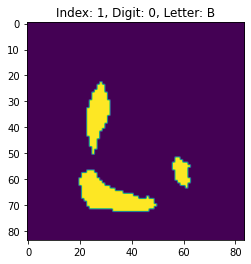

In [65]:
_,d= cv2.threshold(a, 4,8,cv2.THRESH_BINARY)

idx = 1
#img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(d)

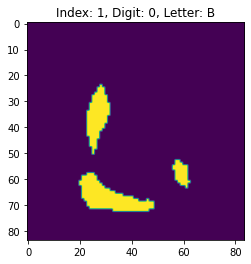

In [66]:
e=cv2.morphologyEx(d, cv2.MORPH_ERODE, (5,5))
plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(e)

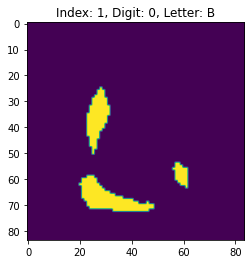

In [67]:
e=cv2.morphologyEx(e, cv2.MORPH_ERODE, (5,5))
plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(e)

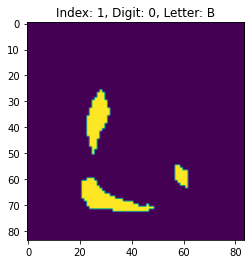

In [68]:
e=cv2.morphologyEx(e, cv2.MORPH_ERODE, (5,5))
plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(e)

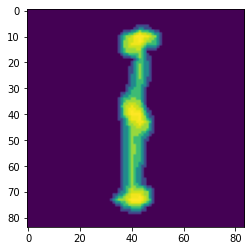

In [5]:
#3배 확대하여 equlization

def eq(img):
    #img=img.reshape(84,84).astype(int)
    img1=np.uint8(cv2.normalize(img, None, 0, 8, cv2.NORM_MINMAX)) 
    return cv2.equalizeHist(img1)

X_train=[ eq(img) for img in x_train ]
plt.imshow(X_train[0])


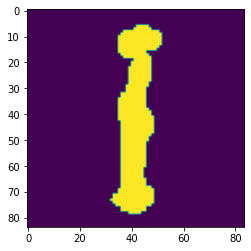

In [9]:
_,dd = cv2.threshold(X_train[0], 7,8,cv2.THRESH_BINARY)
plt.imshow(dd)# 평활화를 못 쓰는 이유

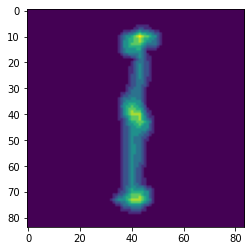

In [4]:
#3배 확대하여 stretching : 오래 걸림.. 컴퓨터야 미안!

def stretch_img(img): #(2048,28,28,1) 반복문으로 넣음
    #img=img.reshape(28,28).astype(int)
    #img=Image.fromarray(img)
    row = 84
    col = 84
    stretch_img = np.zeros((84,84))
    high = 0
    low = 8

    for x in range(1 , row):
        for y in range(1, col):
            if high < img[x,y] :
                high = img[x,y]
            if low > img[x,y]:
                low = img[x,y]
    for x in range(1 , row):
        for y in range(1, col):
            stretch_img[x,y]=int((img[x,y]-low)*8/(high-low))
   
    return stretch_img#스트레칭된 이미지 출력


x__train=[ stretch_img(img) for img in x_train]
plt.imshow(x__train[0])
#stretch_img(x_train[0]) 

### stretch->threshold 전처리 데이터로 학습

In [7]:
#1차적으로 stretch로 학습
x__train=np.array(x__train).reshape(-1,84,84,1) 
x__train=x__train/8 #데이터 8비트라서 255보다는 8이 맞지않을까?

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1
    
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model()
epochs=200

#model.fit(x_train, y_train, epochs=50)


history = model.fit(
  datagen.flow(x__train, y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = x__train.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
128/128 [==============================] - 12s 93ms/step - loss: 4.5022 - accuracy: 0.2632
Epoch 2/200
128/128 [==============================] - 12s 93ms/step - loss: 2.7243 - accuracy: 0.3940
Epoch 3/200
128/128 [==============================] - 12s 93ms/step - loss: 2.1693 - accuracy: 0.4868
Epoch 4/200
128/128 [==============================] - 12s 93ms/step - loss: 1.7771 - accuracy: 0.5547
Epoch 5/200
128/128 [==============================] - 12s 93ms/step - loss: 1.5338 - accuracy: 0.6060
Epoch 6/200
128/128 [==============================] - 12s 93ms/step - loss: 1.3588 - accuracy: 0.6616
Epoch 7/200
128/128 [==============================] - 12s 93ms/step - loss: 1.2190 - accuracy: 0.6880
Epoch 8/200
128/128 [==============================] - 12s 94ms/step - loss: 1.1340 - accuracy: 0.7021
Epoch 9/200
128/128 [==============================] - 12s 93ms/step - loss: 1.0192 - accuracy: 0.7178
Epoch 10/200
128/128 [==============================] - 12s 94ms/step - l

128/128 [==============================] - 12s 94ms/step - loss: 0.1223 - accuracy: 0.9868
Epoch 155/200
128/128 [==============================] - 12s 94ms/step - loss: 0.1417 - accuracy: 0.9775
Epoch 156/200
128/128 [==============================] - 12s 94ms/step - loss: 0.1407 - accuracy: 0.9766
Epoch 157/200
128/128 [==============================] - 12s 94ms/step - loss: 0.1246 - accuracy: 0.9858
Epoch 158/200
128/128 [==============================] - 12s 94ms/step - loss: 0.1348 - accuracy: 0.9824
Epoch 159/200
128/128 [==============================] - 12s 93ms/step - loss: 0.1422 - accuracy: 0.9780
Epoch 160/200
128/128 [==============================] - 12s 94ms/step - loss: 0.1357 - accuracy: 0.9814
Epoch 161/200
128/128 [==============================] - 12s 94ms/step - loss: 0.1442 - accuracy: 0.9761
Epoch 162/200
128/128 [==============================] - 12s 94ms/step - loss: 0.1381 - accuracy: 0.9761
Epoch 163/200
128/128 [==============================] - 12s 94ms/ste

In [11]:
#test1-1 stretch만으로 학습한 데이터 전처리없이 test

x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')
x_test = [cv2.resize(im,dsize=(84,84),interpolation=cv2.INTER_LINEAR) for im in x_test]
x_test = np.array(x_test).reshape(-1, 84, 84, 1)
x_test = x_test/8


submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test), axis=1)

submission.head(50)

#전처리 없이 test를 진행할 경우 비슷한 label만 예측함(2,8,4 반복..)

,id,digit
0,2049,2
1,2050,2
2,2051,2
3,2052,2
4,2053,2
5,2054,2
6,2055,8
7,2056,2
8,2057,2
9,2058,8


In [8]:
#test1-2 stretch만으로 학습한 데이터 전처리(stretch)하고 test

x_test1 = test.drop(['id', 'letter'], axis=1).values
x_test1 = x_test1.reshape(-1, 28, 28, 1).astype('float32')
x_test1 = [cv2.resize(im,dsize=(84,84),interpolation=cv2.INTER_LINEAR) for im in x_test1]
x_test1 = [ stretch_img(img) for img in x_test1 ]
x_test1 = np.array(x_test1).reshape(-1, 84, 84, 1)
x_test1 = x_test1/8



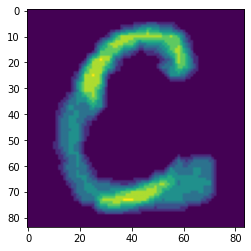

In [15]:
plt.imshow(x_test1[1])

In [10]:
submission1 = pd.read_csv('data/submission.csv')
submission1['digit'] = np.argmax(model.predict(x_test1), axis=1)


,id,digit
0,2049,2
1,2050,6
2,2051,2
3,2052,2
4,2053,2
5,2054,0
6,2055,8
7,2056,2
8,2057,2
9,2058,8


In [17]:
#1차에서 stertched img로 학습된 모델에 이진화 모델로 다시 학습
X__train = x__train*8
X__train = [ cv2.threshold(a, 4,8,cv2.THRESH_BINARY)[1] for a in x__train ] #이진화

#threshold함수는 임계치와 이미지를 return하는것을 잊지말자..

X__train=np.array(X__train).reshape(-1,84,84,1)
X__train=X__train/8 #데이터 8비트라서 255보다는 8이 맞지않을까?

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1
    
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model()
epochs=200

#model.fit(x_train, y_train, epochs=50)


history = model.fit(
  datagen.flow(X__train, y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = X__train.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
128/128 [==============================] - 12s 94ms/step - loss: 2.3625 - accuracy: 0.0996
Epoch 2/200
128/128 [==============================] - 12s 94ms/step - loss: 2.3048 - accuracy: 0.1060
Epoch 3/200
128/128 [==============================] - 12s 94ms/step - loss: 2.3042 - accuracy: 0.0986
Epoch 4/200
128/128 [==============================] - 12s 94ms/step - loss: 2.3037 - accuracy: 0.1084
Epoch 5/200
128/128 [==============================] - 12s 94ms/step - loss: 2.3032 - accuracy: 0.1094
Epoch 6/200
128/128 [==============================] - 12s 94ms/step - loss: 2.3031 - accuracy: 0.1016
Epoch 7/200
128/128 [==============================] - 12s 94ms/step - loss: 2.3032 - accuracy: 0.1060
Epoch 8/200
128/128 [==============================] - 12s 94ms/step - loss: 2.3022 - accuracy: 0.1030
Epoch 9/200
128/128 [==============================] - 12s 94ms/step - loss: 2.3026 - accuracy: 0.1069
Epoch 10/200
128/128 [==============================] - 12s 94ms/step - l

KeyboardInterrupt: 

### test_1 : test데이터는 전처리하지 x - 정확도 매우매우매우 낮음

In [ ]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')
x_test = [cv2.resize(im,dsize=(84,84),interpolation=cv2.INTER_LINEAR) for im in x_test]
#x_test = [ stretch_img(img) for img in x_test ]
#x_test = [ cv2.threshold(a, 4,8,cv2.THRESH_BINARY)[1] for a in x_test ] #이진화
x_test = np.array(x_test).reshape(-1, 84, 84, 1)

# x_test = test.drop(['id', 'digit', 'letter'], axis=1).values
# x_test = x_train.reshape(-1, 28, 28, 1).astype('float32') #resize에러 float32로 바꿔 해결함
# x_test = [cv2.resize(im,dsize=(84,84),interpolation=cv2.INTER_LINEAR) for im in x_train]
# x_test = test.drop(['id', 'letter'], axis=1).values
# #X_test=[ eq(img) for img in x_test ]
# x_test = np.array(x_test).reshape(-1, 84, 84, 1)
x_test = x_test/8

submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test), axis=1)
#submission['digit'] = a
#submission.to_csv('0913_test_stretching_threshold.csv')
submission.head(50)

#submission.to_csv('0913_test_preprocessingX.csv', index=False)

## Train model

In [6]:
def create_cnn_model():
    inputs = Input(shape = (84,84,1))

    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.4)(pool)

    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.4)(pool)

    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [8]:
create_cnn_model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 84, 84, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 84, 84, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 84, 84, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 84, 64)        16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 64)       

### equalization 후 train

In [7]:
# x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
# x_train = x_train.reshape(-1, 28, 28, 1) 
# x_train = x_train/255 # data 정규화
#x_train은 원본, X_train은 equl, x__train은 stretched

X_train=np.array(X_train).reshape(-1,84,84,1)
X_train=X_train/8 #데이터 8비트라서 255보다는 8이 맞지않을까?

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [8]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model()
epochs=200

#model.fit(x_train, y_train, epochs=50)


history = model.fit(
  datagen.flow(X_train, y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = X_train.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
128/128 [==============================] - 10s 78ms/step - loss: 4.3272 - accuracy: 0.2256
Epoch 2/200
128/128 [==============================] - 10s 79ms/step - loss: 2.7722 - accuracy: 0.3442
Epoch 3/200
128/128 [==============================] - 10s 78ms/step - loss: 2.4948 - accuracy: 0.3960
Epoch 4/200
128/128 [==============================] - 10s 78ms/step - loss: 2.3326 - accuracy: 0.4263
Epoch 5/200
128/128 [==============================] - 10s 78ms/step - loss: 2.1773 - accuracy: 0.4785
Epoch 6/200
128/128 [==============================] - 10s 78ms/step - loss: 2.0643 - accuracy: 0.5098
Epoch 7/200
128/128 [==============================] - 10s 78ms/step - loss: 2.0104 - accuracy: 0.5322
Epoch 8/200
128/128 [==============================] - 10s 78ms/step - loss: 1.8949 - accuracy: 0.5605
Epoch 9/200
128/128 [==============================] - 10s 78ms/step - loss: 1.7420 - accuracy: 0.6084
Epoch 10/200
128/128 [==============================] - 10s 78ms/step - l

KeyboardInterrupt: 

## Predict(equlization)

In [13]:
x_test = test.drop(['id', 'letter'], axis=1).values
#X_test=[ eq(img) for img in x_test ]
#X_test = np.array(X_test).reshape(-1, 28, 28, 1)
X_test = X_test/8

submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(X_test), axis=1)
submission.head(50)

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
5,2054,7
6,2055,5
7,2056,3
8,2057,4
9,2058,4


In [14]:
submission.to_csv('0905_preprocess_with_equalization.csv', index=False)

## Stretching->closing->threshold 후 train

In [72]:
# x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
# x_train = x_train.reshape(-1, 28, 28, 1) 
# x_train = x_train/255 # data 정규화
#x_train은 원본, X_train은 equl, x__train은 stretched

x__train=np.array(x__train).reshape(-1,84,84,1)
x__train=x__train/8 #데이터 8비트라서 255보다는 8이 맞지않을까?

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

ValueError: cannot reshape array of size 4096 into shape (84,84,1)

In [11]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model()
epochs=200

#model.fit(x_train, y_train, epochs=50)

history = model.fit(
  datagen.flow(x__train, y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = x__train.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
 23/128 [====>.........................] - ETA: 1:31 - loss: 6.3046 - accuracy: 0.1549

KeyboardInterrupt: 

## Predict(stretching)

In [17]:
x_test = test.drop(['id', 'letter'], axis=1).values
x__test=[ stretch_img(img) for img in x_test]
x__test = np.array(x__test).reshape(-1, 28, 28, 1)
x__test = x__test/8

submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x__test), axis=1)
submission.head(50)

,id,digit
0,2049,2
1,2050,8
2,2051,8
3,2052,0
4,2053,3
5,2054,2
6,2055,5
7,2056,3
8,2057,4
9,2058,4


In [18]:
submission.to_csv('0905_preprocess_with_stretching.csv', index=False)